In [2]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

In [25]:
import tensorflow_addons as tfa

In [ ]:
_URL = "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
path_to_zip = tf.keras.utils.get_file('tiny-imagenet-200.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'tiny-imagenet-200')


In [3]:
PATH = "./tiny-imagenet-200"

In [4]:
train_dir = os.path.join(PATH, 'train')
val_dir = os.path.join(PATH, 'val')

In [33]:
train_image_generator = ImageDataGenerator(validation_split = 0.1, 
                                           featurewise_center=True, 
                                           featurewise_std_normalization=True,
#                                            brightness_range=[0.8,1.2], 
                                           horizontal_flip=True, 
                                           channel_shift_range=0.2)
# validation_image_generator = ImageDataGenerator(rescale=1./255)

In [34]:
learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0005
input_shape = (64, 64, 3)
num_classes = 200
total_train = 90000
total_val = 10000
batch_size = 500
epochs = 50

In [35]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(64, 64),
                                                           class_mode='categorical', 
                                                           subset = 'training')

Found 90000 images belonging to 200 classes.


In [36]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(64, 64),
                                                           class_mode='categorical', 
                                                           subset = 'validation')

Found 10000 images belonging to 200 classes.


In [37]:
sample_training_images, _ = next(train_data_gen)

In [38]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

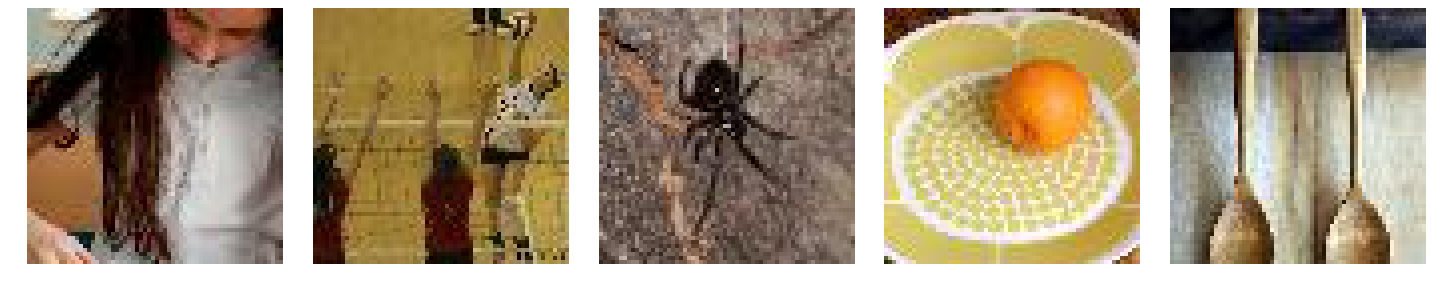

In [39]:
plotImages(sample_training_images[:5])

In [40]:
class LRN2D(tf.keras.layers.Layer):
    """
    This code is adapted from pylearn2.
    License at: https://github.com/lisa-lab/pylearn2/blob/master/LICENSE.txt
    """

    def __init__(self, alpha=1e-4, k=2, beta=0.75, n=5, **kwargs):
        if n % 2 == 0:
            raise NotImplementedError("LRN2D only works with odd n. n provided: " + str(n))
        super(LRN2D, self).__init__(**kwargs)
        self.alpha = alpha
        self.k = k
        self.beta = beta
        self.n = n

    def get_output(self, train):
        X = self.get_input(train)
        b, ch, r, c = K.shape(X)
        half_n = self.n // 2
        input_sqr = K.square(X)
        extra_channels = K.zeros((b, ch + 2 * half_n, r, c))
        input_sqr = K.concatenate([extra_channels[:, :half_n, :, :],
                                   input_sqr,
                                   extra_channels[:, half_n + ch:, :, :]],
                                  axis=1)
        scale = self.k
        for i in range(self.n):
            scale += self.alpha * input_sqr[:, i:i + ch, :, :]
        scale = scale ** self.beta
        return X / scale

    def get_config(self):
        config = {"name": self.__class__.__name__,
                  "alpha": self.alpha,
                  "k": self.k,
                  "beta": self.beta,
                  "n": self.n}
        base_config = super(LRN2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [41]:
def build(input_shape, num_classes):
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.Conv2D(96, (11, 11), strides=(4, 4), padding='same', 
                                     activation='relu', use_bias = 1, 
                                     kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                     bias_initializer = 'zeros', input_shape=input_shape))
    model.add(LRN2D())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))
    
    model.add(tf.keras.layers.Conv2D(256, (5, 5),
                                    activation='relu', use_bias = 1, 
                                    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                    bias_initializer = 'ones'))
    model.add(LRN2D())
    model.add(tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))

    model.add(tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', 
                                     activation='relu', use_bias = 1, 
                                     kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                     bias_initializer = 'zeros'))
    
    model.add(tf.keras.layers.Conv2D(384, (3, 3), strides=(1, 1), padding='same', 
                                     activation='relu', use_bias = 1, 
                                     kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                     bias_initializer = 'ones'))
    
    model.add(tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), padding='same', 
                                     activation='relu', use_bias = 1, 
                                     kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                     bias_initializer = 'ones'))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(4096, activation='relu', use_bias = 1,
                                    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                    bias_initializer = 'ones'))
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(4096, activation='relu', use_bias = 1,
                                    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                    bias_initializer = 'ones'))
    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Dense(num_classes, activation='softmax', use_bias = 1,
                                    kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1e-2),
                                    bias_initializer = 'ones'))
    
    model.summary()
    tf.keras.utils.plot_model(model, to_file='architecture_imagenet.png')
              
    return model

In [42]:
def plot_graph(model, N):
    
    plt.figure(0)
    plt.plot(np.arange(0, N), model.history['loss'], label='Training loss')
    plt.plot(np.arange(0, N), model.history['val_loss'], label='Testing loss')
    plt.title('Training vs Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(1)
    plt.plot(np.arange(0, N), model.history['categorical_accuracy'], label='Top 1 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_categorical_accuracy'], label='Top 1 Testing Accuracy')
    plt.title('Top 1 Training vs Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.figure(2)
    plt.plot(np.arange(0, N), model.history['TopKCategoricalAccuracy'], label='Top 5 Training Accuracy')
    plt.plot(np.arange(0, N), model.history['val_TopKCategoricalAccuracy'], label='Top 5 Testing Accuracy')
    plt.title('Top 5 Training vs Testing Acuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

In [43]:
def model_callbacks(name):
    #checkpoint = tf.keras.callbacks.ModelCheckpoint(name, monitor = 'val_categorical_accuracy',
    #                             mode = 'max', save_best_only = True, verbose = 1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', factor = 0.1,    
                                  patience = 5, verbose = 1)
    return [reduce_lr]

In [44]:
tiny_model = build(input_shape, num_classes)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 16, 16, 96)        34944     
_________________________________________________________________
lr_n2d_4 (LRN2D)             (None, 16, 16, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
lr_n2d_5 (LRN2D)             (None, 4, 4, 256)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 384)        

In [45]:
tiny_model.compile(optimizer = tfa.optimizers.weight_decay_optimizers.SGDW(
                        learning_rate=learning_rate, momentum=momentum, 
                        weight_decay=weight_decay, nesterov=True, name='SGDW'),
                        loss='categorical_crossentropy', 
                        metrics=['categorical_accuracy', 'TopKCategoricalAccuracy'])

In [46]:
tiny_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 16, 16, 96)        34944     
_________________________________________________________________
lr_n2d_4 (LRN2D)             (None, 16, 16, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 96)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 4, 256)         614656    
_________________________________________________________________
lr_n2d_5 (LRN2D)             (None, 4, 4, 256)         0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 2, 2, 384)        

In [47]:
history = tiny_model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 180 steps, validate for 20 steps
Epoch 1/5
 13/180 [=>............................] - ETA: 13:59 - loss: 5.8261 - categorical_accuracy: 0.0045 - TopKCategoricalAccuracy: 0.0262

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/madhurwadhwa/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-47-d478d0a1cdf0>", line 6, in <module>
    validation_steps=total_val // batch_size
  File "/Users/madhurwadhwa/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "/Users/madhurwadhwa/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 1306, in fit_generator
    initial_epoch=initial_epoch)
  File "/Users/madhurwadhwa/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training.py", line 819, in fit
    use_multiprocessing=use_multiprocessing)
  File "/Users/madhurwadhwa/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/keras/engine/training_v2.py", line 342, in fit
    total_epochs=epochs

KeyboardInterrupt: 

In [ ]:
plot_graph(history, epochs)

In [48]:
tf.__version__

'2.1.0'